In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

## EDA

In [2]:
############################
#loading data
train = pd.read_csv('train.csv')
testA = pd.read_csv('testA.csv')

### data overview

In [3]:
#data overview
# print(train.shape, testA.shape)
# train[:50]

In [4]:
######################################################
#check numrical and categorical features
numerical_fea = list(train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea, list(train.columns)))
print(numerical_fea, "\n")
print(category_fea)

['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership', 'annualIncome', 'verificationStatus', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']


### 找出含有Nan值的列

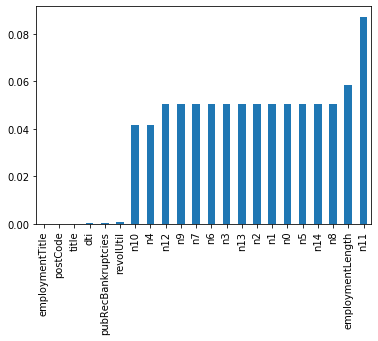

In [5]:
# show all Nan values and its corresopnding feature
missing = train.isnull().sum()/len(train)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

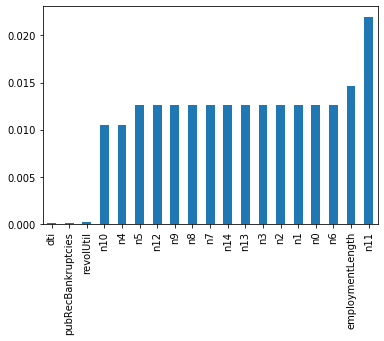

In [6]:
missing = testA.isnull().sum()/len(train)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

### 找出只含有一种值的列

In [7]:
# feature only has one value
# one_value_fea = [col for col in train.columns if train[col].nunique() <= 1]
# one_value_fea_test = [col for col in testA.columns if testA[col].nunique() <= 1]
# print(one_value_fea, one_value_fea_test)

### 判断列中值是否为连续变量或者离散变量

In [8]:
##############################################################################
# check variables in numerical features to judge if it is discrete or continuous
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 15:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea

numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(train,numerical_fea)

In [9]:
print(numerical_serial_fea)

['id', 'loanAmnt', 'interestRate', 'installment', 'employmentTitle', 'annualIncome', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'revolBal', 'revolUtil', 'totalAcc', 'title', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14']


In [10]:
###回过头来看
#discrete vaiables in numerical features analysis
print(numerical_noserial_fea)
for fea in numerical_noserial_fea:
    print(train[fea].value_counts())

['term', 'homeOwnership', 'verificationStatus', 'isDefault', 'purpose', 'pubRecBankruptcies', 'initialListStatus', 'applicationType', 'policyCode', 'n11', 'n12']
3    606902
5    193098
Name: term, dtype: int64
0    395732
1    317660
2     86309
3       185
5        81
4        33
Name: homeOwnership, dtype: int64
1    309810
2    248968
0    241222
Name: verificationStatus, dtype: int64
0    640390
1    159610
Name: isDefault, dtype: int64
0     464096
4     175433
2      52129
5      46276
3      17579
9       9238
1       9106
8       8657
10      5652
7       5373
6       4354
12      1363
11       554
13       190
Name: purpose, dtype: int64
0.0     700076
1.0      93639
2.0       4566
3.0        945
4.0        248
5.0         80
6.0         23
7.0         11
8.0          3
9.0          3
12.0         1
Name: pubRecBankruptcies, dtype: int64
0    466438
1    333562
Name: initialListStatus, dtype: int64
0    784586
1     15414
Name: applicationType, dtype: int64
1.0    800000
Name

In [11]:
# test_numerical_fea = list(testA.select_dtypes(exclude=['object']).columns)
# numerical_serial_test, numerical_noserial_test = get_numerical_serial_fea(testA, test_numerical_fea)
# for fea in numerical_noserial_test:
#     print(testA[fea].value_counts())

### 找到所有的category型的列

In [12]:
#categorical fatures analysis
print(category_fea)
for fea in category_fea:
    print(train[fea].value_counts())

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']
B    233690
C    227118
A    139661
D    119453
E     55661
F     19053
G      5364
Name: grade, dtype: int64
C1    50763
B4    49516
B5    48965
B3    48600
C2    47068
C3    44751
C4    44272
B2    44227
B1    42382
C5    40264
A5    38045
A4    30928
D1    30538
D2    26528
A1    25909
D3    23410
A3    22655
A2    22124
D4    21139
D5    17838
E1    14064
E2    12746
E3    10925
E4     9273
E5     8653
F1     5925
F2     4340
F3     3577
F4     2859
F5     2352
G1     1759
G2     1231
G3      978
G4      751
G5      645
Name: subGrade, dtype: int64
10+ years    262753
2 years       72358
< 1 year      64237
3 years       64152
1 year        52489
5 years       50102
4 years       47985
6 years       37254
8 years       36192
7 years       35407
9 years       30272
Name: employmentLength, dtype: int64
2016-03-01    29066
2015-10-01    25525
2015-07-01    24496
2015-12-01    23245
2014-10-01    21461
        

### 对datatime类型数据处理

In [13]:
####################################################################################
#deal with datetime
#train转化成时间格式  issueDateDT特征表示数据日期离数据集中日期最早的日期（2007-06-01）的天数
train['issueDate'] = pd.to_datetime(train['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
train['issueDate'] = train['issueDate'].apply(lambda x: x-startdate).dt.days
#testA转化成时间格式
testA['issueDate'] = pd.to_datetime(testA['issueDate'], format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
testA['issueDate'] = testA['issueDate'].apply(lambda x: x-startdate).dt.days

In [14]:
print(train.head())

id  loanAmnt  term  interestRate  installment grade subGrade  \
0   0   35000.0     5         19.52       917.97     E       E2   
1   1   18000.0     5         18.49       461.90     D       D2   
2   2   12000.0     5         16.99       298.17     D       D3   
3   3   11000.0     3          7.26       340.96     A       A4   
4   4    3000.0     3         12.99       101.07     C       C2   

   employmentTitle employmentLength  homeOwnership  ...    n5    n6    n7  \
0            320.0          2 years              2  ...   9.0   8.0   4.0   
1         219843.0          5 years              0  ...   NaN   NaN   NaN   
2          31698.0          8 years              0  ...   0.0  21.0   4.0   
3          46854.0        10+ years              1  ...  16.0   4.0   7.0   
4             54.0              NaN              1  ...   4.0   9.0  10.0   

     n8   n9   n10  n11  n12  n13  n14  
0  12.0  2.0   7.0  0.0  0.0  0.0  2.0  
1   NaN  NaN  13.0  NaN  NaN  NaN  NaN  
2   5.0  3.0  

## Feature Engineering

In [15]:
######################################
label = 'isDefault'
numerical_fea.remove(label)

### 对Nan值进行初步填充处理

In [16]:
train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

In [17]:
testA.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      11742
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
purpose                   0
postCode                  0
regionCode                0
dti                      61
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      116
revolBal                  0
revolUtil               127
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                    10111
n1                    10111
n2                    10111
n3                    10111
n4                  

In [18]:
###############################################################
#delete NULL value in employmentTitle postCode title

# train = train.dropna(subset=['employmentTitle', 'postCode', 'title'])
train = train.dropna(subset=['employmentTitle', 'postCode', 'title', 'dti'])

In [19]:
#################################################################
#对缺失值进行处理
#按照平均数填充数值型特征
spec = ['n0', 'n1', 'n2', 'n3', 'n4', 'n5','n6','n7','n8','n9','n10','n11', 'n12', 'n13','n14']
train[list(set(numerical_fea)-set(spec))] = train[list(set(numerical_fea)-set(spec))].fillna(train[list(set(numerical_fea)-set(spec))].mean())
testA[list(set(numerical_fea)-set(spec))] = testA[list(set(numerical_fea)-set(spec))].fillna(train[list(set(numerical_fea)-set(spec))].mean())
#按照众数填充类别型特征
train[category_fea] = train[category_fea].fillna(train[category_fea].mode())
testA[category_fea] = testA[category_fea].fillna(train[category_fea].mode())
###填充特殊
# train[spec] = train[spec].fillna()
# testA[spec] = testA[spec].fillna()

In [20]:
####################################
train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46572
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                    40269
n1                    40269
n2                    40269
n3                  

In [21]:
# testA.isnull().sum()
len(train)

799758

In [22]:
# train['employmentLength'] = train['employmentLength'].fillna(axis=0, method='ffill')
# testA['employmentLength'] = testA['employmentLength'].fillna(axis=0, method='ffill')

In [23]:
################################
train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52488
10+ years    262750
2 years       72357
3 years       64152
4 years       47985
5 years       50101
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64228
NaN           46572
Name: employmentLength, dtype: int64

In [24]:
##############################################

# deal with employmentLength
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
#同时对test train 都进行修改
for data in [train, testA]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [25]:
################################################################
train['employmentLength'].value_counts(dropna=False).sort_index()

0.0      64228
1.0      52488
2.0      72357
3.0      64152
4.0      47985
5.0      50101
6.0      37254
7.0      35407
8.0      36192
9.0      30272
10.0    262750
NaN      46572
Name: employmentLength, dtype: int64

### 对category型数据进行转换

In [26]:
# deal with earliesCreditLine
train['earliesCreditLine']

0         Aug-2001
1         May-2002
2         May-2006
3         May-1999
4         Aug-1977
            ...   
799995    Aug-2011
799996    May-1989
799997    Jul-2002
799998    Jan-1994
799999    Feb-2002
Name: earliesCreditLine, Length: 799758, dtype: object

In [27]:
#######################################################
import calendar

def time2num(d):
    # d = d['earliesCreditLine']
    string = d[:]
    s1 = list(calendar.month_abbr).index(string[:3])
    if s1 < 10: s1 = '0' + str(s1)
    else: s1 = str(s1)
    # print(string[-4:], s1)
    return np.int(string[-4:] + s1)

# time2num(train['earliesCreditLine'][0])
for data in [train, testA]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(time2num)

In [28]:
###########################################
train['earliesCreditLine'].sample(5)

582594    200208
685939    201206
333173    201011
268761    199504
276082    199003
Name: earliesCreditLine, dtype: int64

In [29]:
numerical_fea = list(train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea, list(train.columns)))
print(numerical_fea, "\n")
print(category_fea)

['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'employmentLength', 'homeOwnership', 'annualIncome', 'verificationStatus', 'issueDate', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'earliesCreditLine', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']

['grade', 'subGrade']


### 初步数据映射

In [30]:
# map grade object into int
for data in [train, testA]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

### 缺失值进一步处理

In [31]:
#需要处理的缺失值
spec = ['employmentLength', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5','n6','n7','n8','n9','n10','n11', 'n12', 'n13','n14']

spec_train = spec.copy()
spec_test = spec.copy()

train.reset_index(drop=True,inplace=True)

df_train = train.copy()
df_test = testA.copy()

In [32]:
%%time
#使用随机森林处理缺失值
from sklearn.ensemble import RandomForestRegressor

for _ in range(len(spec)):
    nan_label = spec_train[0]
    df_full = df_train.drop(spec + ['subGrade'], axis=1)
    df_nan = df_train.loc[:, nan_label]

    Ytrain = df_nan[df_nan.notnull()]
    Ytest = df_nan[df_nan.isnull()]
    Xtrain = df_full.iloc[Ytrain.index]
    Xtest = df_full.iloc[Ytest.index]

    rfc = RandomForestRegressor(n_estimators=50, n_jobs=24)
    rfc = rfc.fit(Xtrain, Ytrain)

    Ypredict = rfc.predict(Xtest)

    df_nan[df_nan.isnull()] = Ypredict
    train[nan_label] = df_nan

    spec_train.pop(0)
    print('************finsh', nan_label, '****************')

************finshemploymentLength****************
************finshn0****************
************finshn1****************
************finshn2****************
************finshn3****************
************finshn4****************
************finshn5****************
************finshn6****************
************finshn7****************
************finshn8****************
************finshn9****************
************finshn10****************
************finshn11****************
************finshn12****************
************finshn13****************
************finshn14****************
Wall time: 52min 5s


In [33]:
%%time
for _ in range(len(spec)):
    nan_label = spec_test[0]
    df_full = df_test.drop(spec + ['subGrade'], axis=1)
    df_nan = df_test.loc[:, nan_label]

    Ytrain = df_nan[df_nan.notnull()]
    Ytest = df_nan[df_nan.isnull()]
    Xtrain = df_full.iloc[Ytrain.index]
    Xtest = df_full.iloc[Ytest.index]

    rfc = RandomForestRegressor(n_estimators=50, n_jobs=24)
    rfc = rfc.fit(Xtrain, Ytrain)

    Ypredict = rfc.predict(Xtest)

    df_nan[df_nan.isnull()] = Ypredict
    testA[nan_label] = df_nan
    
    spec_test.pop(0)
    print('************finsh', nan_label, '****************')

************finshemploymentLength****************
************finshn0****************
************finshn1****************
************finshn2****************
************finshn3****************
************finshn4****************
************finshn5****************
************finshn6****************
************finshn7****************
************finshn8****************
************finshn9****************
************finshn10****************
************finshn11****************
************finshn12****************
************finshn13****************
************finshn14****************
Wall time: 10min


In [34]:
train.isnull().sum()

id                    0
loanAmnt              0
term                  0
interestRate          0
installment           0
grade                 0
subGrade              0
employmentTitle       0
employmentLength      0
homeOwnership         0
annualIncome          0
verificationStatus    0
issueDate             0
isDefault             0
purpose               0
postCode              0
regionCode            0
dti                   0
delinquency_2years    0
ficoRangeLow          0
ficoRangeHigh         0
openAcc               0
pubRec                0
pubRecBankruptcies    0
revolBal              0
revolUtil             0
totalAcc              0
initialListStatus     0
applicationType       0
earliesCreditLine     0
title                 0
policyCode            0
n0                    0
n1                    0
n2                    0
n3                    0
n4                    0
n5                    0
n6                    0
n7                    0
n8                    0
n9              

In [35]:
testA.isnull().sum()

id                    0
loanAmnt              0
term                  0
interestRate          0
installment           0
grade                 0
subGrade              0
employmentTitle       0
employmentLength      0
homeOwnership         0
annualIncome          0
verificationStatus    0
issueDate             0
purpose               0
postCode              0
regionCode            0
dti                   0
delinquency_2years    0
ficoRangeLow          0
ficoRangeHigh         0
openAcc               0
pubRec                0
pubRecBankruptcies    0
revolBal              0
revolUtil             0
totalAcc              0
initialListStatus     0
applicationType       0
earliesCreditLine     0
title                 0
policyCode            0
n0                    0
n1                    0
n2                    0
n3                    0
n4                    0
n5                    0
n6                    0
n7                    0
n8                    0
n9                    0
n10             

### 异常值处理

In [36]:
###############################################
def find_outliers_by_3segama(data, fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [37]:
numerical_fea = ['loanAmnt', 'interestRate', 'installment', 'openAcc', 'revolBal', 'revolUtil', 'totalAcc', 'earliesCreditLine', 'ficoRangeLow', 'ficoRangeHigh', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5','n6','n7','n8','n9','n10', 'n13', 'n14', 'issueDate']

# 'n0', 'n1', 'n2', 'n3', 'n4', 'n5','n6','n7','n8','n9','n10',

In [78]:
t = train.copy()
# for fea in numerical_fea:
#     t = find_outliers_by_3segama(t, fea)
#     print(t[fea+'_outliers'].value_counts())
#     print(t.groupby(fea+'_outliers')['isDefault'].sum())
#     print('*'*10)

In [39]:
#过滤异常值
# for fea in numerical_fea:
#     t = t[t[fea+'_outliers']=='正常值']
#     t = t.reset_index(drop=True) 
#     t = t.drop([fea+'_outliers'], axis=1)

In [40]:
# t.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,5,E2,320.0,2.00,2,...,9.00,8.00,4.0,12.00,2.00,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,4,D2,219843.0,5.00,0,...,6.86,3.92,10.1,12.62,7.52,13.0,0.0,0.0,0.0,3.4
2,2,12000.0,5,16.99,298.17,4,D3,31698.0,8.00,0,...,0.00,21.00,4.0,5.00,3.00,11.0,0.0,0.0,0.0,4.0
3,4,3000.0,3,12.99,101.07,3,C2,54.0,5.06,1,...,4.00,9.00,10.0,15.00,7.00,12.0,0.0,0.0,0.0,4.0
4,6,2050.0,3,7.69,63.95,1,A4,180083.0,9.00,0,...,11.00,3.00,10.0,18.00,3.00,12.0,0.0,0.0,0.0,3.0


In [79]:
len(t)

799758

In [80]:
# t.columns
# t.head()
###############################
te = testA.copy()

In [81]:
train_x = t.copy()
test_x = te.copy()

In [82]:
train_x.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,5,E2,320.0,2.00,2,...,9.00,8.00,4.0,12.00,2.00,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,4,D2,219843.0,5.00,0,...,6.86,3.92,10.1,12.62,7.52,13.0,0.0,0.0,0.0,3.4
2,2,12000.0,5,16.99,298.17,4,D3,31698.0,8.00,0,...,0.00,21.00,4.0,5.00,3.00,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,1,A4,46854.0,10.00,1,...,16.00,4.00,7.0,21.00,6.00,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,3,C2,54.0,5.06,1,...,4.00,9.00,10.0,15.00,7.00,12.0,0.0,0.0,0.0,4.0


### 数据映射

In [83]:
for f in train_x.columns:
    print(f, '类型数：', train_x[f].nunique())

id类型数：799758
loanAmnt类型数：1539
term类型数：2
interestRate类型数：641
installment类型数：72350
grade类型数：7
subGrade类型数：35
employmentTitle类型数：248681
employmentLength类型数：389
homeOwnership类型数：6
annualIncome类型数：44923
verificationStatus类型数：3
issueDate类型数：139
isDefault类型数：2
purpose类型数：14
postCode类型数：932
regionCode类型数：51
dti类型数：6321
delinquency_2years类型数：30
ficoRangeLow类型数：39
ficoRangeHigh类型数：39
openAcc类型数：75
pubRec类型数：32
pubRecBankruptcies类型数：12
revolBal类型数：71109
revolUtil类型数：1287
totalAcc类型数：134
initialListStatus类型数：2
applicationType类型数：2
earliesCreditLine类型数：720
title类型数：39644
policyCode类型数：1
n0类型数：278
n1类型数：500
n2类型数：742
n3类型数：748
n4类型数：659
n5类型数：1153
n6类型数：1481
n7类型数：1074
n8类型数：1851
n9类型数：727
n10类型数：794
n11类型数：25
n12类型数：30
n13类型数：159
n14类型数：348


In [46]:
# cate_features = ['term', 'grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
#                  'applicationType', 'initialListStatus', 'title', 'policyCode']
# for f in cate_features:
#     print(f, '类型数：', train_x[f].nunique())

In [84]:
# 类型数在2之上，又不是高维稀疏的
train_x = pd.get_dummies(train_x, columns=['subGrade', 'homeOwnership', 'purpose', 'regionCode','verificationStatus'], drop_first=True)

In [85]:
test_x = pd.get_dummies(test_x, columns=['subGrade', 'homeOwnership', 'purpose', 'regionCode','verificationStatus'], drop_first=True)

In [86]:
train_x.reset_index(drop=True)

,id,loanAmnt,term,interestRate,installment,grade,employmentTitle,employmentLength,annualIncome,issueDate,...,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50,verificationStatus_1,verificationStatus_2
0,0,35000.0,5,19.52,917.97,5,320.0,2.00,110000.0,2587,...,0,0,0,0,0,0,0,0,0,1
1,1,18000.0,5,18.49,461.90,4,219843.0,5.00,46000.0,1888,...,0,0,0,0,0,0,0,0,0,1
2,2,12000.0,5,16.99,298.17,4,31698.0,8.00,74000.0,3044,...,0,0,0,0,0,0,0,0,0,1
3,3,11000.0,3,7.26,340.96,1,46854.0,10.00,118000.0,2983,...,0,0,0,0,0,0,0,0,1,0
4,4,3000.0,3,12.99,101.07,3,54.0,5.06,29000.0,3196,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799753,799995,25000.0,3,14.49,860.41,3,2659.0,7.00,72000.0,3318,...,0,0,0,0,0,0,0,0,0,0
799754,799996,17000.0,3,7.90,531.94,1,29205.0,10.00,99000.0,2131,...,0,0,0,0,0,0,0,0,0,1
799755,799997,6000.0,3,13.33,203.12,3,2582.0,10.00,65000.0,3044,...,0,0,0,0,0,0,0,0,0,1
799756,799998,19200.0,3,6.92,592.14,1,151.0,10.00,96000.0,2802,...,0,0,0,0,0,0,0,0,0,1


In [87]:
# 高维类别特征需要进行转换
for f in ['employmentTitle', 'title', 'postCode']:
    train_x[f+'_cnts'] = train_x.groupby([f])['id'].transform('count')
    train_x[f+'_rank'] = train_x.groupby([f])['id'].rank(ascending=False).astype(int)
    del train_x[f]

In [88]:
for f in ['employmentTitle','title', 'postCode']:
    test_x[f+'_cnts'] = test_x.groupby([f])['id'].transform('count')
    test_x[f+'_rank'] = test_x.groupby([f])['id'].rank(ascending=False).astype(int)
    del test_x[f]

In [89]:
print(len(train_x))
print(len(test_x))

799758
200000


In [53]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# train_x.to_csv('clean_train.csv')
# testA.to_csv('clean_testA.csv')
# train_x.to_csv('clean_train_rf.csv')
# test_x.to_csv('clean_testA_rf.csv')
train_x.to_csv('clean_train_rf_noise.csv')
test_x.to_csv('clean_testA_rf_noise.csv')

## 构建训练模型

In [54]:
# train_x = pd.read_csv('clean_train_1.csv')
# test_x = pd.read_csv('clean_testA_1.csv')

In [90]:
train_x.head()

,id,loanAmnt,term,interestRate,installment,grade,employmentLength,annualIncome,issueDate,isDefault,...,regionCode_49,regionCode_50,verificationStatus_1,verificationStatus_2,employmentTitle_cnts,employmentTitle_rank,title_cnts,title_rank,postCode_cnts,postCode_rank
0,0,35000.0,5,19.52,917.97,5,2.00,110000.0,2587,1,...,0,0,0,1,1121,1121,7005,7005,2074,2074
1,1,18000.0,5,18.49,461.90,4,5.00,46000.0,1888,0,...,0,0,0,1,125,125,28,28,3786,3786
2,2,12000.0,5,16.99,298.17,4,8.00,74000.0,3044,0,...,0,0,0,1,1,1,393195,393195,1753,1753
3,3,11000.0,3,7.26,340.96,1,10.00,118000.0,2983,0,...,0,0,1,0,2,2,148168,148168,551,551
4,4,3000.0,3,12.99,101.07,3,5.06,29000.0,3196,0,...,0,0,0,1,50921,50921,4729,4729,1722,1722


In [91]:
test_x.head()

,id,loanAmnt,term,interestRate,installment,grade,employmentLength,annualIncome,issueDate,dti,...,regionCode_49,regionCode_50,verificationStatus_1,verificationStatus_2,employmentTitle_cnts,employmentTitle_rank,title_cnts,title_rank,postCode_cnts,postCode_rank
0,800000,14000.0,3,10.99,458.28,2,10.0,80000.0,2587,10.56,...,0,0,0,0,9,9,98066,98066,202,202
1,800001,20000.0,5,14.65,472.14,3,10.0,50000.0,2952,21.40,...,0,0,0,0,1,1,11034,11034,1172,1172
2,800002,12000.0,3,19.99,445.91,4,2.0,60000.0,3410,33.50,...,0,0,0,1,1,1,98066,98065,300,300
3,800003,17500.0,5,14.31,410.02,3,4.0,37000.0,2710,13.95,...,0,0,1,0,8,8,37175,37175,340,340
4,800004,35000.0,3,17.09,1249.42,4,0.0,80000.0,3775,24.97,...,0,0,1,0,1,1,98066,98064,536,536


In [92]:
features = [f for f in train_x.columns if f not in ['id', 'Unnamed: 0','isDefault', 'issueDate', 'policyCode']]

x_train = train_x[features]
x_test = test_x[features]

y_train = train_x['isDefault']

In [118]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            # params = {
            #     'boosting_type': 'gbdt',
            #     'objective': 'binary',
            #     'metric': 'auc',
            #     'min_child_weight': 5,
            #     'num_leaves': 2 ** 5,
            #     'lambda_l2': 10,
            #     'feature_fraction': 0.8,
            #     'bagging_fraction': 0.8,
            #     'bagging_freq': 4,
            #     'learning_rate': 0.1,
            #     'seed': 2020,
            #     'nthread': 28,
            #     'n_jobs':24,
            #     'silent': True,
            #     'verbose': -1,
            # }
            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'learning_rate': 0.01,
                'num_leaves': 14,
                'max_depth': 19,
                'min_data_in_leaf': 37,
                'min_child_weight':1.6,
                'bagging_fraction': 0.98,
                'feature_fraction': 0.69,
                'bagging_freq': 96,
                'reg_lambda': 9,
                'reg_alpha': 7,
                'min_split_gain': 0.4,
                'nthread': 8,
                'seed': 2020,
                'silent': True
    }

            model = clf.train(params, train_matrix, num_boost_round=15000, valid_sets=[train_matrix, valid_matrix], verbose_eval=1000,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      'device': 'gpu'
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            # params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
            #           'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            # params = {'learning_rate' : 0.03, 'depth': 7, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bernoulli',
            #           'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'task_type':'GPU', 'allow_writing_files': False}
            params = {'learning_rate':0.03, 'depth': 9, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'random_seed': 42, 'task_type': 'GPU', 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
       
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [119]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat") 
    return cat_train, cat_test

In [60]:
#贝叶斯调参
# from sklearn.model_selection import cross_val_score

# """定义优化函数"""
# def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
#               min_child_weight, min_split_gain, reg_lambda, reg_alpha):
#     # 建立模型
#     model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', bjective='binary', metric='auc',
#                                    learning_rate=0.1, n_estimators=5000,
#                                    num_leaves=int(num_leaves), max_depth=int(max_depth), 
#                                    bagging_fraction=round(bagging_fraction, 2), feature_fraction=round(feature_fraction, 2),
#                                    bagging_freq=int(bagging_freq), min_data_in_leaf=int(min_data_in_leaf),
#                                    min_child_weight=min_child_weight, min_split_gain=min_split_gain,
#                                    reg_lambda=reg_lambda, reg_alpha=reg_alpha,
#                                    n_jobs= 24
#                                   )
    
#     val = cross_val_score(model_lgb, x_train, y_train, cv=5, scoring='roc_auc').mean()
    
#     return val


In [61]:
# from bayes_opt import BayesianOptimization
# """定义优化参数"""
# bayes_lgb = BayesianOptimization(
#     rf_cv_lgb, 
#     {
#         'num_leaves':(10, 200),
#         'max_depth':(3, 20),
#         'bagging_fraction':(0.5, 1.0),
#         'feature_fraction':(0.5, 1.0),
#         'bagging_freq':(0, 100),
#         'min_data_in_leaf':(10,100),
#         'min_child_weight':(0, 10),
#         'min_split_gain':(0.0, 1.0),
#         'reg_alpha':(0.0, 10),
#         'reg_lambda':(0.0, 10),
#     }
# )

In [62]:
# %%time
# bayes_lgb.maximize(n_iter=10)

]min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning]bagging_fraction is set=0.69, subsample=1.0 will be ignored. Current value: bagging_fraction=0.69
[LightGBM] [Warning]bagging_freq is set=99, subsample_freq=0 will be ignored. Current value: bagging_freq=99
[LightGBM] [Warning]Unknown parameter: bjective
[LightGBM] [Warning]feature_fraction is set=0.67, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67
[LightGBM] [Warning]min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning]bagging_fraction is set=0.69, subsample=1.0 will be ignored. Current value: bagging_fraction=0.69
[LightGBM] [Warning]bagging_freq is set=99, subsample_freq=0 will be ignored. Current value: bagging_freq=99
| 8 | 0.6993 | 0.6913 | 99.31 | 0.6724 | 7.323 | 0.3614 | 74.83 | 0.1674 | 71.45 | 0.4511 | 6.993 |
[LightGBM] [Warning]Unknown parameter: bjective
[L

In [63]:
# lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)  
# bayes_lgb.max 

{'target': 0.7259261694317372,
 'params': {'bagging_fraction': 0.9450628478642027,
  'bagging_freq': 94.06287526678155,
  'feature_fraction': 0.9024857803662265,
  'max_depth': 18.06222280141808,
  'min_child_weight': 7.521666069242668,
  'min_data_in_leaf': 96.2593868289768,
  'min_split_gain': 0.5916914901143545,
  'num_leaves': 14.043318965743138,
  'reg_alpha': 9.32827918573944,
  'reg_lambda': 5.561104245931667}}

In [95]:
#默认参数
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)  

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.743548	valid_1's auc: 0.726692
[400]	training's auc: 0.756404	valid_1's auc: 0.727685
Early stopping, best iteration is:
[383]	training's auc: 0.755449	valid_1's auc: 0.727718
[0.7277181390981768]
************************************ 2 ************************************
[LightGBM] [Warning]num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning]Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.742726	valid_1's auc: 0.731272
[400]	training's auc: 0.755665	valid_1's auc: 0.73247
[600]	training's auc: 0.766677	valid_1's auc: 0.732814
[800]	training's auc: 0.777062	valid_1's auc: 0.733002
Early stopping, best iteration is:
[780]	training's auc: 0.775977	valid_1's auc: 0.733057
[0.7277181390981768, 0.733057

In [120]:
lgb_train_1, lgb_test_1 = lgb_model(x_train, y_train, x_test)  #datawhale 参数

************************************ 1 ************************************
[LightGBM] [Warning]Unknown parameter: silent
[LightGBM] [Warning]Unknown parameter: silent
[LightGBM] [Info]Number of positive: 127684, number of negative: 512122
[LightGBM] [Warning]Auto-choosing col-wise multi-threading, the overhead of testing was 0.313789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]Total Bins 6787
[LightGBM] [Info]Number of data points in the train set: 639806, number of used features: 143
[LightGBM] [Warning]Unknown parameter: silent
[LightGBM] [Info][binary:BoostFromScore]: pavg=0.199567 -> initscore=-1.389004
[LightGBM] [Info]Start training from score -1.389004
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.727118	valid_1's auc: 0.72123
[2000]	training's auc: 0.733085	valid_1's auc: 0.725081
[3000]	training's auc: 0.736531	valid_1's auc: 0.726349
[4000]	training's auc: 0.739398	valid_1's auc: 0.727088
[5000]

In [ ]:
#自己调整的参数


In [64]:
# xgb_train, xgb_test = xgb_model(x_train, y_train, x_test)

In [96]:
cat_train, cat_test = cat_model(x_train, y_train, x_test) 
# params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
    #                  'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}

************************************ 1 ************************************
0:	learn: 0.3981767	test: 0.3980000	best: 0.3980000 (0)	total: 102ms	remaining: 33m 50s
500:	learn: 0.3767270	test: 0.3779144	best: 0.3779144 (500)	total: 37.2s	remaining: 24m 6s
1000:	learn: 0.3751928	test: 0.3771749	best: 0.3771749 (1000)	total: 1m 15s	remaining: 23m 53s
1500:	learn: 0.3740797	test: 0.3768313	best: 0.3768310 (1499)	total: 1m 51s	remaining: 22m 58s
2000:	learn: 0.3731213	test: 0.3766472	best: 0.3766472 (2000)	total: 2m 28s	remaining: 22m 14s
2500:	learn: 0.3722625	test: 0.3765527	best: 0.3765527 (2500)	total: 3m 4s	remaining: 21m 30s
3000:	learn: 0.3714659	test: 0.3764626	best: 0.3764612 (2999)	total: 3m 41s	remaining: 20m 54s
3500:	learn: 0.3707140	test: 0.3764077	best: 0.3764043 (3483)	total: 4m 17s	remaining: 20m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3763758679
bestIteration = 3797

Shrink model to first 3798 iterations.
[0.729320136589779]
****************

In [102]:
cat_train_1, cat_test_1 = cat_model(x_train, y_train, x_test)
# params = {learning_rate：0.03, 'depth': 7, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bernoulli',
#                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, task_type="GPU", 'allow_writing_files': False}

************************************ 1 ************************************
0:	learn: 0.3986922	test: 0.3985103	best: 0.3985103 (0)	total: 89.7ms	remaining: 29m 54s
500:	learn: 0.3759610	test: 0.3778384	best: 0.3778384 (500)	total: 29.1s	remaining: 18m 54s
1000:	learn: 0.3737087	test: 0.3770434	best: 0.3770434 (1000)	total: 58.5s	remaining: 18m 29s
1500:	learn: 0.3719938	test: 0.3767392	best: 0.3767392 (1500)	total: 1m 27s	remaining: 17m 56s
2000:	learn: 0.3704765	test: 0.3765829	best: 0.3765829 (2000)	total: 1m 56s	remaining: 17m 29s
2500:	learn: 0.3690641	test: 0.3764831	best: 0.3764831 (2500)	total: 2m 28s	remaining: 17m 21s
3000:	learn: 0.3677029	test: 0.3764049	best: 0.3764029 (2986)	total: 3m 2s	remaining: 17m 12s
bestTest = 0.3763661513
bestIteration = 3221
Shrink model to first 3222 iterations.
[0.7294265322171744]
************************************ 2 ************************************
0:	learn: 0.3984944	test: 0.3993379	best: 0.3993379 (0)	total: 63.9ms	remaining: 21m 17s


In [107]:
cat_train_2, cat_test_3 = cat_model(x_train, y_train, x_test)
# params = {learning_rate：0.03, 'depth': 9, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bernoulli',
#                      'od_type': 'Iter', 'random_seed': 42, task_type="GPU", 'allow_writing_files': False}

************************************ 1 ************************************
0:	learn: 0.3986509	test: 0.3984682	best: 0.3984682 (0)	total: 104ms	remaining: 34m 32s
500:	learn: 0.3734644	test: 0.3774663	best: 0.3774663 (500)	total: 40.2s	remaining: 26m 3s
1000:	learn: 0.3693627	test: 0.3767828	best: 0.3767828 (1000)	total: 1m 21s	remaining: 25m 41s
bestTest = 0.3765751926
bestIteration = 1425
Shrink model to first 1426 iterations.
[0.7284555974737466]
************************************ 2 ************************************
0:	learn: 0.3984591	test: 0.3992999	best: 0.3992999 (0)	total: 95.8ms	remaining: 31m 55s
500:	learn: 0.3736867	test: 0.3769131	best: 0.3769131 (500)	total: 45.1s	remaining: 29m 15s
1000:	learn: 0.3695494	test: 0.3762084	best: 0.3762084 (1000)	total: 1m 44s	remaining: 33m 6s
1500:	learn: 0.3661682	test: 0.3759440	best: 0.3759440 (1500)	total: 2m 39s	remaining: 32m 42s
bestTest = 0.3758672752
bestIteration = 1697
Shrink model to first 1698 iterations.
[0.728455597473

KeyboardInterrupt: 

In [66]:
# lgb_data = pd.DataFrame(lgb_test,columns=['label'])
# # print(lgb_data)
# lgb_data.to_csv('lgb_data.csv')
# xgb_data = pd.DataFrame(xgb_test,columns=['label'])
# # print(lgb_data)
# xgb_data.to_csv('xgb_data.csv')
# cat_data = pd.DataFrame(cat_test,columns=['label'])
# # print(lgb_data)
# cat_data.to_csv('cat_data.csv')

### 模型融合

In [121]:
# rh_test = lgb_test*0.3 + xgb_test*0.7
# rh_test = lgb_test_1*0.5 + cat_test_1*0.5
# rh_test = xgb_test

In [124]:
rh_test =lgb_test_1

In [125]:
# testA['isDefault'] = rh_test
testA['isDefault'] = rh_test

In [126]:
# testA[['id','isDefault']].to_csv('test_sub.csv', index=False)
# testA[['id','isDefault']].to_csv('test_sub_2.csv', index=False)
testA[['id','isDefault']].to_csv('lgb_sub.csv', index=False)